In [1]:
import pytorch_lightning as pl
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import os
import torchmetrics
import numpy
import matplotlib
import numpy
import seaborn

In [2]:
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.loss_fn = nn.NLLLoss()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

    def training_step(self, batch, batch_idx):
        X, y = batch
        # Compute prediction error
        pred = model(X)
        loss = self.loss_fn(pred, y)
        accuracy = sum(pred.argmax(1) == y)/len(y)
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        pred = model(x)
        test_accuracy = sum(pred.argmax(1) == y)/len(y)
        test_loss = self.loss_fn(pred, y)
        #self.test_accuracy.update(pred, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_accuracy", test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00001)

In [3]:
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(training_data, batch_size=64, num_workers=os.cpu_count()//2)
test_loader = DataLoader(test_data, batch_size=64, num_workers=os.cpu_count()//2)

In [11]:
trainer = pl.Trainer(max_epochs=5, accelerator='mps', devices=1)
model = LitModel()
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | loss_fn    | NLLLoss    | 0     
1 | convlayer1 | Sequential | 384   
2 | convlayer2 | Sequential | 18.6 K
3 | fc1        | Linear     | 1.4 M 
4 | drop       | Dropout    | 0     
5 | fc2        | Linear     | 72.1 K
6 | fc3        | Linear     | 1.2 K 
------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
trainer.test(model, dataloaders=test_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8144000172615051     │
│         test_loss         │    0.35463589429855347    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.35463589429855347, 'test_accuracy': 0.8144000172615051}]

In [6]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
count = 0
correct = 0
pred_all = torch.empty(0)
y_all = torch.empty(0)
for x, y in iter(test_loader):
    with torch.no_grad():
        pred = model(x).max(1).indices
        pred_all = torch.cat((pred_all, pred), 0)
        y_all = torch.cat((y_all, y), 0)
count += len(y_all)
correct += sum(y_all == pred_all)
print(f'{correct} correct out of {count}')

8773 correct out of 10000


[Text(0, 0.5, 'T-shirt/top'),
 Text(0, 1.5, 'Trouser'),
 Text(0, 2.5, 'Pullover'),
 Text(0, 3.5, 'Dress'),
 Text(0, 4.5, 'Coat'),
 Text(0, 5.5, 'Sandal'),
 Text(0, 6.5, 'Shirt'),
 Text(0, 7.5, 'Sneaker'),
 Text(0, 8.5, 'Bag'),
 Text(0, 9.5, 'Ankle Boot')]

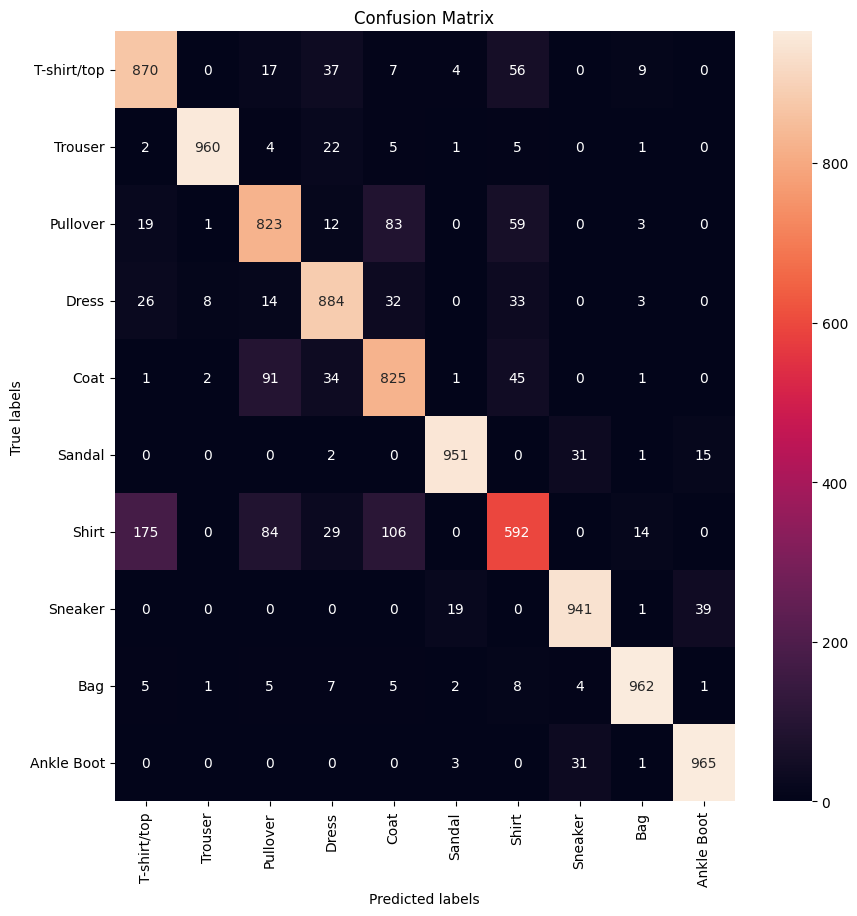

In [7]:
conf = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=10)
cm = conf(pred_all, y_all)
cm = cm.numpy()
cm = cm.astype(int)
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, ax = matplotlib.pyplot.subplots(figsize=(10,10))  
ax= matplotlib.pyplot.subplot()
seaborn.heatmap(cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)